In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=98a0e08f99263454284754f3d575de00b5a295297baa8d3b3433b3c3c1f80584
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Let's import the libraries we will need
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf

In [5]:
# initiate SparkContext
conf = SparkConf().setAppName("ChihaoShen").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
spark

# Q1

In [6]:
id='1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.txt')

id='1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c1.txt')

id='1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('c2.txt')

In [7]:
# get data
data = sc.textFile('data.txt').map(lambda line: [float(x) for x in line.split()])
random_centroids = sc.textFile('c1.txt').map(lambda line: [float(x) for x in line.split()]).collect()
dispersed_centroids = sc.textFile('c2.txt').map(lambda line: [float(x) for x in line.split()]).collect()

In [8]:
# constants
MAX_ITER = 20
k = 10

In [9]:
# some necessary functions
def assign_Euc(point, centroids):
  # Euclidean distance
  distances = []
  for centroid in centroids:
    d = 0
    for a, b in zip(point, centroid):
      d += (a - b) ** 2
    distances.append(d)
  return [distances.index(min(distances)), min(distances)]

In [10]:
# random centroid
random_costs = []
centroids = random_centroids
for i in range(MAX_ITER):
  clusters = data.map(lambda x: (assign_Euc(x, centroids), x)).map(lambda x: (x[0][0], [x[0][1], x[1]]))
  random_costs.append(clusters.map(lambda x: x[1][0]).reduce(lambda x, y: x + y))
  centroids = clusters.map(lambda x: (x[0], x[1][1])).groupByKey().mapValues(lambda points: [sum(x) / len(points) for x in zip(*points)]).values().collect()
print(random_costs)
# [623660345.3064113, 509862908.2975454, 485480681.8720084, 463997011.68501294, 460969266.5729968, 460537847.9827684, 460313099.6535447, 460003523.8894081, 459570539.3177352, 459021103.3422909, 458490656.1919812, 457944232.5879751, 457558005.1986773, 457290136.35230196, 457050555.05956286, 456892235.61535585, 456703630.7370345, 456404203.01897514, 456177800.541994, 455986871.0273468]

[623660345.3064113, 509862908.2975454, 485480681.8720084, 463997011.68501294, 460969266.5729968, 460537847.9827684, 460313099.6535447, 460003523.8894081, 459570539.3177352, 459021103.3422909, 458490656.1919812, 457944232.5879751, 457558005.1986773, 457290136.35230196, 457050555.05956286, 456892235.61535585, 456703630.7370345, 456404203.01897514, 456177800.541994, 455986871.0273468]


In [11]:
# dispersed centroid
dispersed_costs = []
centroids = dispersed_centroids
for i in range(MAX_ITER):
  clusters = data.map(lambda x: (assign_Euc(x, centroids), x)).map(lambda x: (x[0][0], [x[0][1], x[1]]))
  dispersed_costs.append(clusters.map(lambda x: x[1][0]).reduce(lambda x, y: x + y))
  centroids = clusters.map(lambda x: (x[0], x[1][1])).groupByKey().mapValues(lambda points: [sum(x) / len(points) for x in zip(*points)]).values().collect()
print(dispersed_costs)
# [438747790.02791756, 249803933.62600276, 194494814.40631253, 169804841.4515432, 156295748.8062759, 149094208.10896596, 142508531.61961532, 132303869.40652987, 117170969.83719075, 108547377.17857003, 102237203.3179959, 98278015.74975666, 95630226.12177408, 93793314.051193, 92377131.96821065, 91541606.25423889, 91045573.83042458, 90752240.10140811, 90470170.18122731, 90216416.1756313]

[438747790.02791756, 249803933.62600276, 194494814.40631253, 169804841.4515432, 156295748.8062759, 149094208.10896596, 142508531.61961532, 132303869.40652987, 117170969.83719075, 108547377.17857003, 102237203.3179959, 98278015.74975666, 95630226.12177408, 93793314.051193, 92377131.96821065, 91541606.25423889, 91045573.83042458, 90752240.10140811, 90470170.18122731, 90216416.1756313]


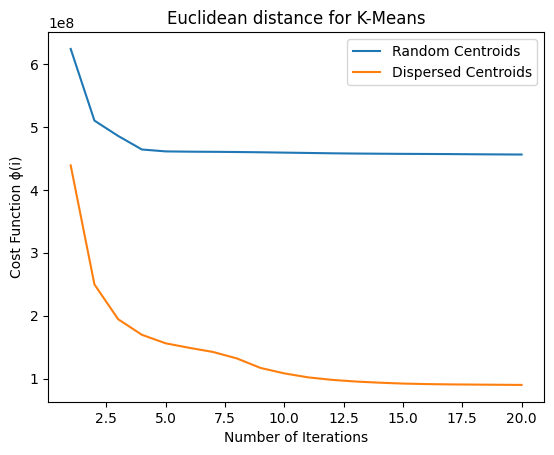

In [12]:
# plot
plt.plot(range(1, MAX_ITER + 1), random_costs, label='Random Centroids')
plt.plot(range(1, MAX_ITER + 1), dispersed_costs, label='Dispersed Centroids')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost Function ϕ(i)')
plt.title('Euclidean distance for K-Means')
plt.legend()
plt.show()

In [13]:
# percentage change
print(f"percentage change in cost after 10 iterations of random centroids is {(random_costs[0] - random_costs[10]) / random_costs[0]}")
print(f"percentage change in cost after 10 iterations of dispersed centroids is {(dispersed_costs[0] - dispersed_costs[10]) / dispersed_costs[0]}")

percentage change in cost after 10 iterations of random centroids is 0.2648391714456053
percentage change in cost after 10 iterations of dispersed centroids is 0.7669795594605946


In [14]:
# some necessary functions
def assign_Manh(point, centroids):
  # Euclidean distance
  distances = []
  for centroid in centroids:
    d = 0
    for a, b in zip(point, centroid):
      d += abs(a - b)
    distances.append(d)
  return [distances.index(min(distances)), min(distances)]

In [15]:
# random centroid
random_costs = []
centroids = random_centroids
for i in range(MAX_ITER):
  clusters = data.map(lambda x: (assign_Manh(x, centroids), x)).map(lambda x: (x[0][0], [x[0][1], x[1]]))
  random_costs.append(clusters.map(lambda x: x[1][0]).reduce(lambda x, y: x + y))
  centroids = clusters.map(lambda x: (x[0], x[1][1])).groupByKey().mapValues(lambda points: [sum(x) / len(points) for x in zip(*points)]).values().collect()
print(random_costs)
# [550117.1419999995, 464869.2758792968, 470897.382277298, 483914.4091733451, 489216.07100343006, 487629.66854997986, 483711.9232137447, 475330.77349323116, 474871.2388463625, 457232.92011507833, 447494.38619735045, 450915.0125766762, 451250.36707256647, 451974.59553974995, 451570.36406995635, 452739.01136645605, 453082.73028718407, 450583.670860298, 450368.74931674276, 449011.36372551974]

[550117.1419999995, 464869.2758792968, 470897.382277298, 483914.4091733451, 489216.07100343006, 487629.66854997986, 483711.9232137447, 475330.77349323116, 474871.2388463625, 457232.92011507833, 447494.38619735045, 450915.0125766762, 451250.36707256647, 451974.59553974995, 451570.36406995635, 452739.01136645605, 453082.73028718407, 450583.670860298, 450368.74931674276, 449011.36372551974]


In [16]:
# dispersed centroid
dispersed_costs = []
centroids = dispersed_centroids
for i in range(MAX_ITER):
  clusters = data.map(lambda x: (assign_Manh(x, centroids), x)).map(lambda x: (x[0][0], [x[0][1], x[1]]))
  dispersed_costs.append(clusters.map(lambda x: x[1][0]).reduce(lambda x, y: x + y))
  centroids = clusters.map(lambda x: (x[0], x[1][1])).groupByKey().mapValues(lambda points: [sum(x) / len(points) for x in zip(*points)]).values().collect()
print(dispersed_costs)
# [1433739.3099999954, 1084488.7769648773, 973431.7146620404, 895934.592563071, 865128.3352940815, 845846.647031348, 827219.5827561248, 803590.3456011117, 756039.5172761207, 717332.9025432297, 694587.9252526882, 684444.5019967904, 674574.7475478561, 667409.469916028, 663556.6278215044, 660162.7772287563, 656041.3222947121, 653036.7540731612, 651112.4262522729, 649689.0131843555]

[1433739.3099999954, 1084488.7769648773, 973431.7146620404, 895934.592563071, 865128.3352940815, 845846.647031348, 827219.5827561248, 803590.3456011117, 756039.5172761207, 717332.9025432297, 694587.9252526882, 684444.5019967904, 674574.7475478561, 667409.469916028, 663556.6278215044, 660162.7772287563, 656041.3222947121, 653036.7540731612, 651112.4262522729, 649689.0131843555]


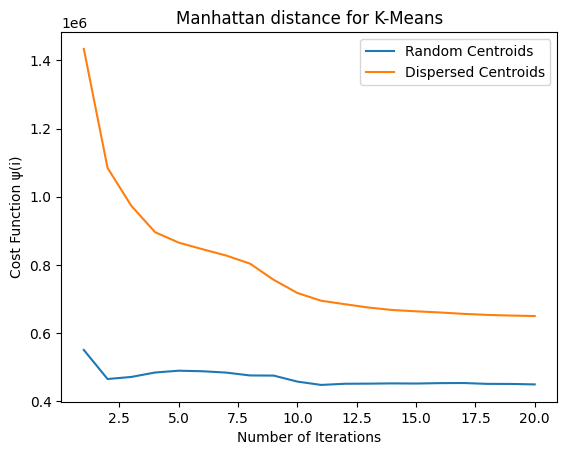

In [17]:
# plot
plt.plot(range(1, MAX_ITER + 1), random_costs, label='Random Centroids')
plt.plot(range(1, MAX_ITER + 1), dispersed_costs, label='Dispersed Centroids')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost Function ψ(i)')
plt.title('Manhattan distance for K-Means')
plt.legend()
plt.show()

In [18]:
# percentage change
print(f"Percentage change in cost after 10 iterations of random centroids is {(random_costs[0] - random_costs[10]) / random_costs[0]}")
print(f"Percentage change in cost after 10 iterations of dispersed centroids is {(dispersed_costs[0] - dispersed_costs[10]) / dispersed_costs[0]}")

Percentage change in cost after 10 iterations of random centroids is 0.18654709691385904
Percentage change in cost after 10 iterations of dispersed centroids is 0.515540991023891


# Q2

In [19]:
import numpy as np


In [20]:
user_shows_path = "/content/drive/MyDrive/CSC4008/ass/ass4/user-shows.txt"
shows_path = "/content/drive/MyDrive/CSC4008/ass/ass4/shows.txt"

In [21]:
R = np.loadtxt(user_shows_path)
f = open(shows_path, 'r')
shows = []
for i in f.readlines():
  shows.append(i.replace('\n', '').replace('"', ''))

In [22]:
# 1. Compute the matrices P and Q
P = np.diag(np.sum(R, axis=1))
Q = np.diag(np.sum(R, axis=0))
print(P)
print(Q)

[[35.  0.  0. ...  0.  0.  0.]
 [ 0. 26.  0. ...  0.  0.  0.]
 [ 0.  0. 44. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  5.  0.  0.]
 [ 0.  0.  0. ...  0. 30.  0.]
 [ 0.  0.  0. ...  0.  0. 19.]]
[[1089.    0.    0. ...    0.    0.    0.]
 [   0. 3350.    0. ...    0.    0.    0.]
 [   0.    0. 3187. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...  358.    0.    0.]
 [   0.    0.    0. ...    0.  294.    0.]
 [   0.    0.    0. ...    0.    0.    6.]]


In [23]:
# 2. compute Γ for the user-user collaborative filtering and give the five highest TV shows
sqrt_P = P
non_zero_elements = np.nonzero(sqrt_P)
sqrt_P[non_zero_elements] = 1 / np.sqrt(sqrt_P[non_zero_elements])
user_gamma = np.dot(np.dot(np.dot(np.dot(sqrt_P, R), R.T), sqrt_P), R)
print(user_gamma)

[[2.38694740e+02 6.23151008e+02 5.71703488e+02 ... 4.83274279e+01
  4.21198998e+01 1.13858692e+00]
 [1.33694107e+02 4.19077188e+02 4.02414436e+02 ... 4.54437612e+01
  3.30921828e+01 8.77272416e-01]
 [2.11111685e+02 7.62741976e+02 6.67605242e+02 ... 6.40146288e+01
  6.02625946e+01 1.19935843e+00]
 ...
 [1.15245426e+02 4.80104040e+02 3.20864824e+02 ... 2.40099342e+01
  2.40418785e+01 7.23715847e-01]
 [1.08032264e+02 3.39089352e+02 3.65569102e+02 ... 4.03555262e+01
  2.95288560e+01 6.09419012e-01]
 [1.66264271e+02 5.63207472e+02 5.31698345e+02 ... 4.65848688e+01
  4.67656966e+01 7.94526464e-01]]


In [24]:
rcmd = np.argsort(user_gamma[499, :100])[-5:][::-1]
top_five = [shows[i] for i in rcmd]
print("From all the TV shows, the five that have the highest similarity scores for Alex are:")
for i in top_five:
  print(i)

From all the TV shows, the five that have the highest similarity scores for Alex are:
FOX 28 News at 10pm
Family Guy
2009 NCAA Basketball Tournament
NBC 4 at Eleven
Two and a Half Men


In [25]:
# 2. compute Γ for the movie-movie collaborative filtering and give the five highest TV shows
sqrt_Q = Q
non_zero_elements = np.nonzero(sqrt_Q)
sqrt_Q[non_zero_elements] = 1 / np.sqrt(sqrt_Q[non_zero_elements])
item_gamma = np.dot(np.dot(np.dot(np.dot(R, sqrt_Q), R.T), R), sqrt_Q)
print(item_gamma)

[[ 9.60753925 13.10317571 12.23318216 ...  3.21104654  3.1958345
   0.5460337 ]
 [ 4.36209878  7.69620486  7.48711214 ...  2.5659889   2.16145674
   0.35271962]
 [ 8.38784944 16.61201283 14.99775822 ...  4.48553862  4.63638336
   0.57006572]
 ...
 [ 1.35142806  3.06385022  2.19960949 ...  0.505658    0.56492792
   0.10841235]
 [ 4.30668052  7.52755966  7.98718359 ...  2.76060253  2.31754441
   0.32536496]
 [ 4.09378095  7.67177907  7.51854526 ...  2.04293639  2.28842818
   0.26419831]]


In [26]:
rcmd = np.argsort(item_gamma[499, :100])[-5:][::-1]
top_five = [shows[i] for i in rcmd]
print("From all the TV shows, the five that have the highest similarity scores for Alex are:")
for i in top_five:
  print(i)

From all the TV shows, the five that have the highest similarity scores for Alex are:
FOX 28 News at 10pm
Family Guy
NBC 4 at Eleven
2009 NCAA Basketball Tournament
Access Hollywood
